# Internal Resistance Calculation for Small Vertical Axis Wind Turbine
**Author:** Ian Eykamp, **Date:** 6/7/2023

## Purpose
All generators have some amount of internal resistance, which allows there to be a variable voltage drop across the terminals, even if the generator always outputs the same emf. By connecting various resistors across the terminals (using no resistance as a baseline), I can figure out what the internal resistance is.

### Import libraries
`plecs_helper.py` is a file I created which defines some helper functions for nice plots and getting data off the oscilloscope and out of PLECS.

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from UliEngineering.EngineerIO import format_value
from si_prefix import si_format
import plecs_helper as helper
%matplotlib
%matplotlib inline

# Imports and setup
from pint import UnitRegistry
from scipy.signal import find_peaks
from scipy.optimize import fsolve

# pandas display using scientific notation
# pd.set_option('display.float_format', lambda x: f'{x:.3e}')

# use pint
units = UnitRegistry()
units.default_format = "~P.2f"

def to_decibels(arr, dc_gain = 0):
    return np.log10(np.abs(arr)) * 20 + dc_gain

Using matplotlib backend: TkAgg


Newfile1.csv: unloaded
Newfile2.csv: 100kOhm
Newfile3.csv: 100Ohm
Newfile4.csv: 100Ohm / 2
Newfile5.csv: 24Ohm
Newfile6.csv: 6.8Ohm

In [151]:
# Import data
(df_high_res, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/high_density_unloaded.csv", ch1 = "unloaded")
(df_upstream_resistors, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/upstream_resistors.csv", ch1 = "upstream_resistors")
(df_no_braking, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/no_braking.csv", ch1 = "no_braking")
(df_yes_braking, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/delta_6.8Ohm_braking.csv", ch1 = "yes_braking")

(df_1, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/Newfile1.csv", ch1 = "unloaded")
(df_2, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/Newfile2.csv", ch1 = "100kOhm")
(df_3, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/Newfile3.csv", ch1 = "100Ohm")
(df_4, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/Newfile4.csv", ch1 = "50Ohm")
(df_5, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/Newfile5.csv", ch1 = "24Ohm")
(df_6, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/Newfile6.csv", ch1 = "6.8Ohm")

# Combine all variables into one for convenience
df = df_1.set_index("t").join([df_2.set_index("t"), df_3.set_index("t"), df_4.set_index("t"), df_5.set_index("t"), df_6.set_index("t")]).reset_index()
print(df.head(20))

        t  unloaded   100kOhm    100Ohm     50Ohm     24Ohm    6.8Ohm
0  -0.600       NaN       NaN       NaN       NaN       NaN       NaN
1  -0.595       NaN       NaN       NaN       NaN       NaN       NaN
2  -0.590       NaN       NaN       NaN       NaN       NaN       NaN
3  -0.585       NaN       NaN       NaN       NaN       NaN       NaN
4  -0.580       NaN       NaN       NaN       NaN       NaN       NaN
5  -0.575       NaN       NaN       NaN       NaN       NaN       NaN
6  -0.570       NaN       NaN       NaN       NaN       NaN       NaN
7  -0.565       NaN       NaN       NaN       NaN       NaN       NaN
8  -0.560       NaN       NaN       NaN       NaN       NaN       NaN
9  -0.555  0.979996  1.019996  0.979996  0.859996  0.999996  0.959991
10 -0.550  0.999996  1.019996  0.959991  0.839991  1.020000  0.979996
11 -0.545  0.999996  1.019996  0.959991  0.819991  1.020000  0.959996
12 -0.545  0.999996  1.019996  0.959991  0.819991  1.020000  0.979996
13 -0.545  0.999996 

Expected R1 using R2 = 0 Ohms:
Expected R1 using R2 = 100000.0 Ohms:
R1 = 21951 Ohms
R1 = 30000 Ohms
R1 = 40000 Ohms
R1 = 95238 Ohms
R1 = 400000 Ohms
Expected R1 using R2 = 100 Ohms:
R1 = 233 Ohms
R1 = 650 Ohms
Expected R1 using R2 = 50 Ohms:
R1 = 135 Ohms
R1 = 246 Ohms
R1 = 570 Ohms
Expected R1 using R2 = 24 Ohms:
R1 = 110 Ohms
R1 = 390 Ohms
Expected R1 using R2 = 6.8 Ohms:
R1 = 97 Ohms


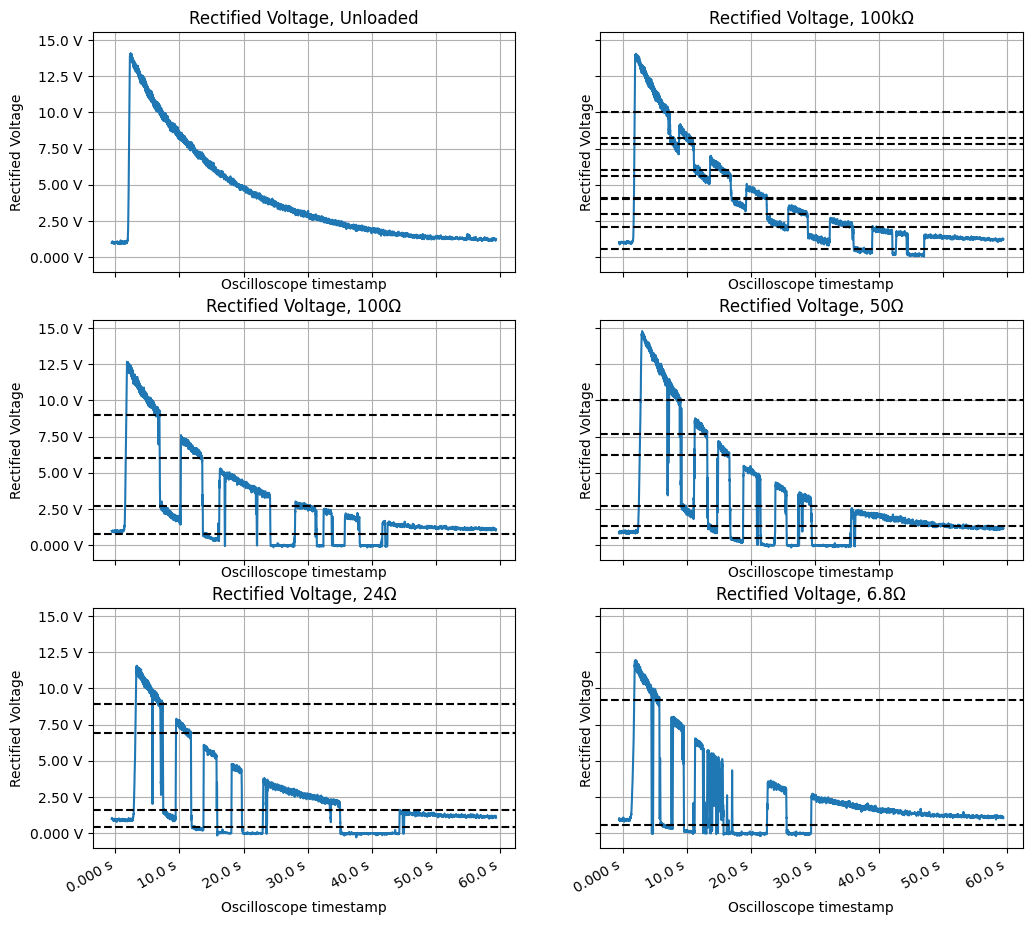

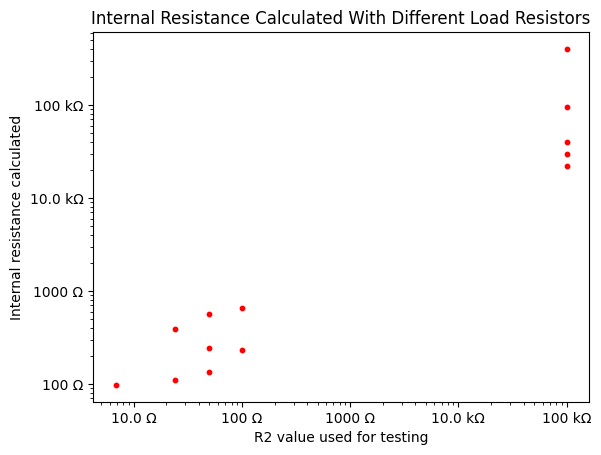

In [152]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows = 3, ncols = 2, sharex = True, sharey = True, figsize = (12, 12))
fig.autofmt_xdate()
helper.axes_labels("Oscilloscope timestamp", "s", "Rectified Voltage", "V", title = "Rectified Voltage, Unloaded", ax = ax1)
ax1.plot(df["t"], df["unloaded"], label = "unloaded")
ax1.grid()
helper.axes_labels("Oscilloscope timestamp", "s", "Rectified Voltage", "V", title = "Rectified Voltage, 100kΩ", ax = ax2)
ax2.plot(df["t"], df["100kOhm"], label = "100kOhm")
ax2.grid()
helper.axes_labels("Oscilloscope timestamp", "s", "Rectified Voltage", "V", title = "Rectified Voltage, 100Ω", ax = ax3)
ax3.plot(df["t"], df["100Ohm"], label = "100Ohm")
ax3.grid()
helper.axes_labels("Oscilloscope timestamp", "s", "Rectified Voltage", "V", title = "Rectified Voltage, 50Ω", ax = ax4)
ax4.plot(df["t"], df["50Ohm"], label = "50Ohm")
ax4.grid()
helper.axes_labels("Oscilloscope timestamp", "s", "Rectified Voltage", "V", title = "Rectified Voltage, 24Ω", ax = ax5)
ax5.plot(df["t"], df["24Ohm"], label = "24Ohm")
ax5.grid()
helper.axes_labels("Oscilloscope timestamp", "s", "Rectified Voltage", "V", title = "Rectified Voltage, 6.8Ω", ax = ax6)
ax6.plot(df["t"], df["6.8Ohm"], label = "6.8Ohm")
ax6.grid()

def calculate_R1(Vin, Vout, R2):
    R1 = R2 * (Vin / Vout - 1)
    return R1

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
resistors = [0, 1e5, 100, 50, 24, 6.8]

voltage_comparison_list = [
    [], # no voltage drops for unloaded test case
    [(10, 8.2), (7.8, 6), (5.6, 4), (4.1, 2.1), (3, 0.6)], 
    [(9, 2.7), (6, 0.8)], 
    [(10, 2.7), (7.7, 1.3), (6.2, 0.5)], 
    [(8.9, 1.6), (6.9, 0.4)], 
    [(9.2, 0.6)]
]

fig, total_ax = plt.subplots()

R1_values = []
for ax, resistor_value, voltage_comparisons in zip(axes, resistors, voltage_comparison_list):
    print(f"Expected R1 using R2 = {resistor_value} Ohms:")
    internal_resistances = []
    for voltage_comparison in voltage_comparisons:
        ax.axhline(voltage_comparison[0], color = "black", linestyle = "dashed")
        ax.axhline(voltage_comparison[1], color = "black", linestyle = "dashed")
        internal_resistance = calculate_R1(Vin = voltage_comparison[0], Vout = voltage_comparison[1], R2 = resistor_value)
        print(f"R1 = {round(internal_resistance)} Ohms")
        internal_resistances.append(internal_resistance)
        plt.scatter([resistor_value], [internal_resistance], s = 10, c = "red", label = f"R2 = {resistor_value} Ohms")
    R1_values.append(internal_resistances)
total_ax.set_xscale('log')
total_ax.set_yscale('log')
helper.axes_labels("R2 value used for testing", "Ω", "Internal resistance calculated", "Ω", title = "Internal Resistance Calculated With Different Load Resistors", ax = total_ax)

time constant = 21.8sec, offset = 12.5V


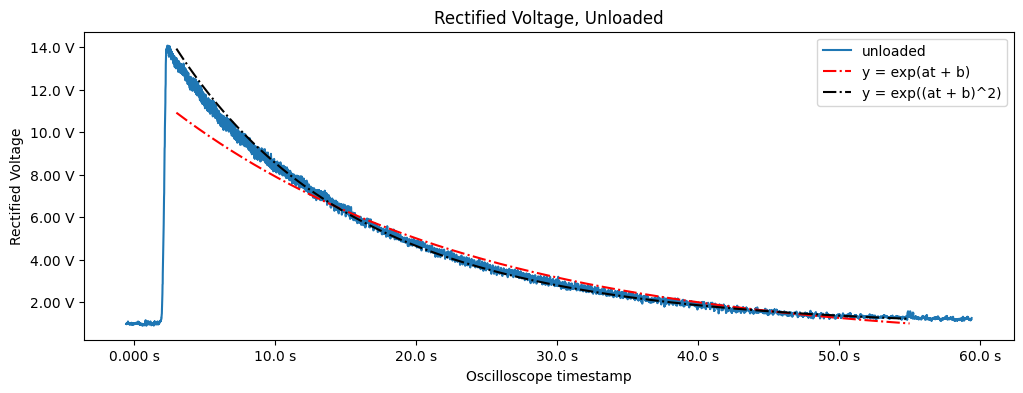

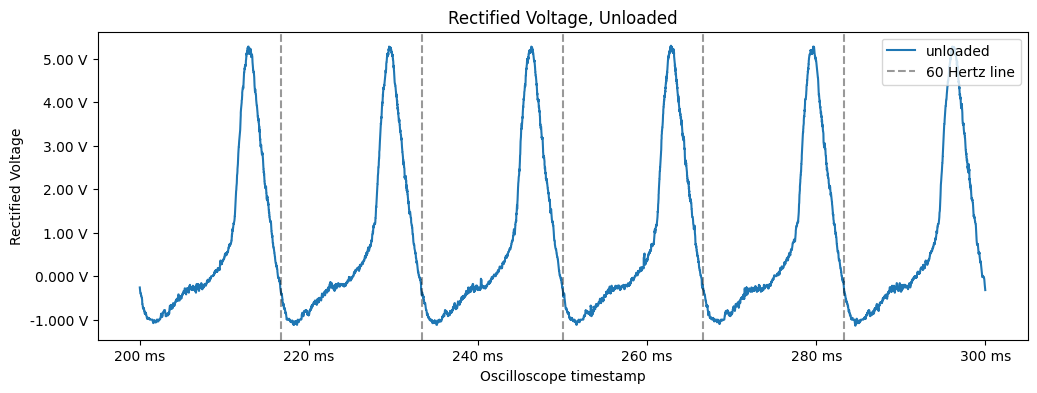

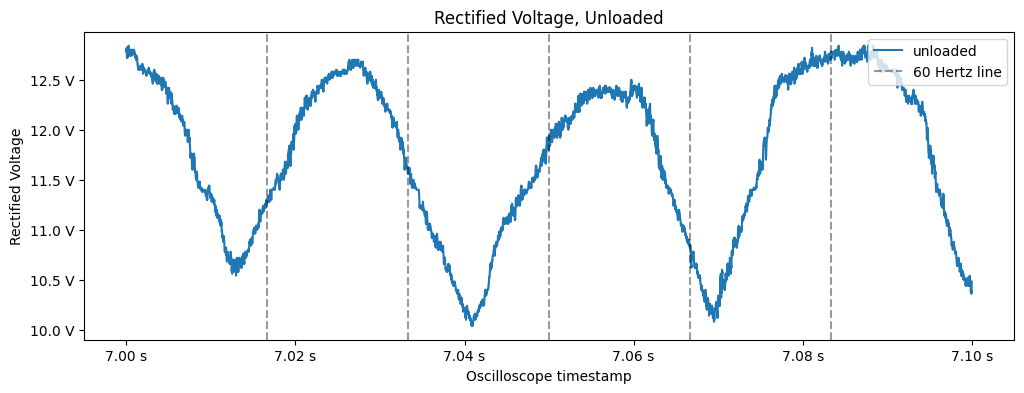

In [153]:
fig, ax = plt.subplots(figsize = (12, 4))
helper.axes_labels("Oscilloscope timestamp", "s", "Rectified Voltage", "V", title = "Rectified Voltage, Unloaded", ax = ax)
ax.plot(df["t"], df["unloaded"], label = "unloaded")

linear_ts = (3, 55)
df_linreg = df[(df["t"] > linear_ts[0]) & (df["t"] < linear_ts[1])]

x = df_linreg["t"]
y_exp = np.log(df_linreg["unloaded"])
y_sqr = np.sqrt(np.log(df_linreg["unloaded"]))
A = np.vstack([x, np.ones(len(x))]).T
a_exp, b_exp = np.linalg.lstsq(A, y_exp, rcond=None)[0]
a_sqr, b_sqr = np.linalg.lstsq(A, y_sqr, rcond=None)[0]
tau = -1 / a_exp
offset_factor = np.exp(b_exp)
ax.plot(df_linreg["t"], offset_factor * np.exp(-df_linreg["t"] / tau), linestyle = "dashdot", color = "red", label = "y = exp(at + b)")
ax.plot(df_linreg["t"], 1 * np.exp((df_linreg["t"] * a_sqr + b_sqr) ** 2), linestyle = "dashdot", color = "black", label = "y = exp((at + b)^2)")
ax.legend(loc = "upper right")
print(f"time constant = {np.round(tau, 1)}sec, offset = {np.round(offset_factor, 1)}V")

baseline_region = (200e-3, 300e-3)
df_zoom_baseline = df_high_res[(df_high_res["t"] > baseline_region[0]) & (df_high_res["t"] < baseline_region[1])]
hertz_60 = np.arange(1000) * 1 / 60

fig, ax = plt.subplots(figsize = (12, 4))
helper.axes_labels("Oscilloscope timestamp", "s", "Rectified Voltage", "V", title = "Rectified Voltage, Unloaded", ax = ax)
ax.plot(df_zoom_baseline["t"], df_zoom_baseline["unloaded"], label = "unloaded")

my_label = "60 Hertz line"
for vline in hertz_60:
    if (vline > baseline_region[0]) and (vline < baseline_region[1]):
        ax.axvline(x = vline, color = "black", linestyle = "dashed", alpha = 0.4, label = my_label)
        my_label = None
ax.legend(loc = "upper right")

spinning_region = (7.0, 7.1)
df_zoom_spinning = df_high_res[(df_high_res["t"] > spinning_region[0]) & (df_high_res["t"] < spinning_region[1])]


fig, ax = plt.subplots(figsize = (12, 4))
helper.axes_labels("Oscilloscope timestamp", "s", "Rectified Voltage", "V", title = "Rectified Voltage, Unloaded", ax = ax)
ax.plot(df_zoom_spinning["t"], df_zoom_spinning["unloaded"], label = "unloaded")

my_label = "60 Hertz line"
for vline in hertz_60:
    if (vline > spinning_region[0]) and (vline < spinning_region[1]):
        ax.axvline(x = vline, color = "black", linestyle = "dashed", alpha = 0.4, label = my_label)
        my_label = None
ax.legend(loc = "upper right")

time constant = 20.1sec, offset = 20.1V
a_inv = 0.01139599459940468, b_inv = -0.06073008712458958
time constant = 11.6sec, offset = 4.2V


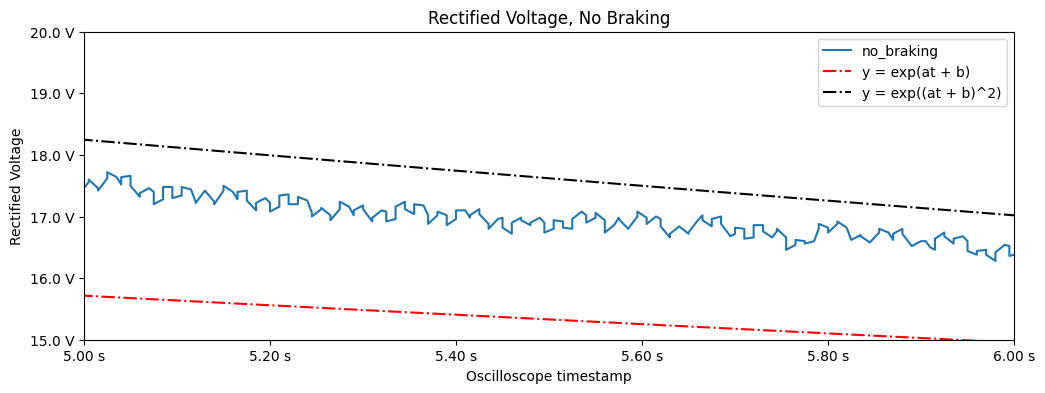

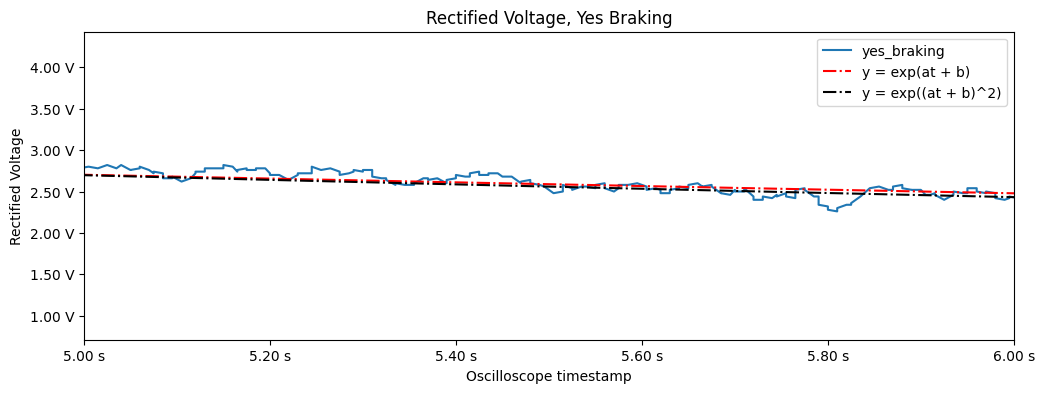

: 

In [188]:
fig, ax = plt.subplots(figsize = (12, 4))
helper.axes_labels("Oscilloscope timestamp", "s", "Rectified Voltage", "V", title = "Rectified Voltage, No Braking", ax = ax)
ax.plot(df_no_braking["t"], df_no_braking["no_braking"], label = "no_braking")

linear_ts = (3, 55)
df_linreg = df_no_braking[(df_no_braking["t"] > linear_ts[0]) & (df_no_braking["t"] < linear_ts[1])]

x = df_linreg["t"]
y_exp = np.log(df_linreg["no_braking"])
y_sqr = np.sqrt(np.log(df_linreg["no_braking"]))
y_inv = 1 / df_linreg["no_braking"]
A = np.vstack([x, np.ones(len(x))]).T
a_exp, b_exp = np.linalg.lstsq(A, y_exp, rcond=None)[0]
a_sqr, b_sqr = np.linalg.lstsq(A, y_sqr, rcond=None)[0]
a_inv, b_inv = np.linalg.lstsq(A, y_inv, rcond=None)[0]
tau = -1 / a_exp
offset_factor = np.exp(b_exp)
ax.plot(df_linreg["t"], offset_factor * np.exp(-df_linreg["t"] / tau), linestyle = "dashdot", color = "red", label = "y = exp(at + b)")
ax.plot(df_linreg["t"], 1 * np.exp((df_linreg["t"] * a_sqr + b_sqr) ** 2), linestyle = "dashdot", color = "black", label = "y = exp((at + b)^2)")
# ax.plot(df_linreg["t"], 1 / (a_inv * df_linreg["t"] + b_inv), linestyle = "dashdot", color = "green", label = "y = 1 / (at + b)")
# ax.plot(df_linreg["t"], y_inv, linestyle = "solid", color = "green", label = "y = 1 / (at + b)")
# ax.plot(df_linreg["t"], a_inv * df_linreg["t"] + b_inv, linestyle = "dashdot", color = "green", label = "y = 1 / (at + b)")
ax.set_ylim(15, 20)
ax.set_xlim(5, 6)
ax.legend(loc = "upper right")
print(f"time constant = {np.round(tau, 1)}sec, offset = {np.round(offset_factor, 1)}V")
print(f"a_inv = {a_inv}, b_inv = {b_inv}")

fig, ax = plt.subplots(figsize = (12, 4))
helper.axes_labels("Oscilloscope timestamp", "s", "Rectified Voltage", "V", title = "Rectified Voltage, Yes Braking", ax = ax)
ax.plot(df_yes_braking["t"], df_yes_braking["yes_braking"], label = "yes_braking")

linear_ts = (3, 15)
df_linreg = df_yes_braking[(df_yes_braking["t"] > linear_ts[0]) & (df_yes_braking["t"] < linear_ts[1])]

x = df_linreg["t"]
y_exp = np.log(df_linreg["yes_braking"])
y_sqr = np.sqrt(np.log(df_linreg["yes_braking"]))
A = np.vstack([x, np.ones(len(x))]).T
a_exp, b_exp = np.linalg.lstsq(A, y_exp, rcond=None)[0]
a_sqr, b_sqr = np.linalg.lstsq(A, y_sqr, rcond=None)[0]
tau = -1 / a_exp
offset_factor = np.exp(b_exp)
ax.plot(df_linreg["t"], offset_factor * np.exp(-df_linreg["t"] / tau), linestyle = "dashdot", color = "red", label = "y = exp(at + b)")
ax.plot(df_linreg["t"], 1 * np.exp((df_linreg["t"] * a_sqr + b_sqr) ** 2), linestyle = "dashdot", color = "black", label = "y = exp((at + b)^2)")
ax.set_xlim(5, 6)
ax.legend(loc = "upper right")
print(f"time constant = {np.round(tau, 1)}sec, offset = {np.round(offset_factor, 1)}V")